In [51]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns


import nltk
import unicodedata
import scipy.stats as stats
from scipy.stats import mannwhitneyu


import re

## Orginal Df

In [2]:
df = pd.read_csv('master_train_data.csv', index_col=0).reset_index().drop(columns=['index', 'id', 'prompt_id'])

In [3]:
len(df.loc[0,'text'].split(' '))

132

In [4]:
df['word_length'] = df['text'].apply(lambda x: len(str(x).split(' ')))


In [5]:
len(df.loc[1, 'text'].split(' '))

135

In [6]:
df

,text,generated,word_length
0,Having students of different ages in the same ...,1,132
1,After researching examples of successful group...,1,135
2,"For many students and teachers, a four-day sch...",1,304
3,"Delve into what motivates you to take action, ...",1,105
4,"Dear Senator, If one could sum up the definiti...",0,527
...,...,...,...
3794,Honesty is a fundamental part of any healthy r...,1,205
3795,"Dear Senator, As you may know, there is a huge...",0,562
3796,The electoral collage should be disbanded. Not...,0,346
3797,First impressions often form the basis for how...,1,132


In [7]:
round(df[df.generated == 1].word_length.mean())

201

In [8]:
round(df[df.generated == 0].word_length.mean())

553

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3799 entries, 0 to 3798
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         3799 non-null   object
 1   generated    3799 non-null   int64 
 2   word_length  3799 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 89.2+ KB


In [10]:
sample = '''The Electoral College, an institution that has been a cornerstone of the United States' electoral process since its inception, has faced growing criticism and calls for reform in recent years. Advocates for the disbandment of the Electoral College argue that this outdated system is no longer aligned with the democratic principles that underpin the nation. In examining the numerous flaws inherent in the Electoral College, it becomes evident that its continued existence poses significant challenges to the fairness and representativeness of the American electoral system.

One primary concern with the Electoral College lies in its potential to undermine the principle of one person, one vote. The winner-takes-all approach used by most states means that voters in non-battleground states have significantly less influence over the outcome of a presidential election. This disenfranchisement of voters outside swing states creates an inequitable system where the preferences of citizens in states with predetermined political leanings are largely ignored. Disbanding the Electoral College would pave the way for a more equitable and inclusive electoral process, where every vote carries equal weight, fostering a true representation of the people's will.

Furthermore, the Electoral College can lead to situations where the candidate who secures the popular vote does not necessarily win the presidency. This discrepancy has occurred multiple times in American history, most notably in the elections of 1876, 1888, and 2000. Such occurrences not only defy the fundamental democratic principle of majority rule but also shake public trust in the electoral system. By transitioning to a popular vote system, the nation can ensure that the candidate with the most votes across the entire country assumes the highest office, reinforcing the democratic ideals upon which the United States was founded.

The regional disparities exacerbated by the Electoral College also contribute to the case for its disbandment. Candidates often focus their campaigns on a select few swing states, neglecting the unique concerns and interests of citizens in other regions. This results in policies and political decisions that may not align with the needs of a diverse and geographically expansive nation. Abolishing the Electoral College would encourage candidates to engage with a broader spectrum of voters, fostering a more comprehensive understanding of the nation's varied challenges and aspirations.

Moreover, the Electoral College perpetuates a winner-takes-all mentality, discouraging third-party candidates from participating in the electoral process. Knowing that their chances of winning any electoral votes are minimal, these candidates face insurmountable barriers to entry, limiting the diversity of voices and ideas in the political arena. A shift toward a popular vote system would remove these barriers, encouraging a more pluralistic democracy that embraces a wider range of perspectives and policy proposals.

In conclusion, the argument for disbanding the Electoral College revolves around the core principles of democracy, fairness, and equal representation. By transitioning to a popular vote system, the United States has the opportunity to revitalize its electoral process, ensuring that every citizen's voice is heard and that the president is elected by a true majority of the people. As the nation continues to evolve, the call for reform gains momentum, driven by the belief that a more equitable and representative electoral system is essential for the vitality of American democracy.'''

In [11]:
len(sample.split(' '))

526

In [12]:
df.generated.value_counts()

1    2424
0    1375
Name: generated, dtype: int64

### Build contracted word count for each row

In [13]:
contracted_words = [
    "aren't", "there's", "can't", "they'd", "couldn't", "they'll", "didn't", "doesn't",
    "don't", "hadn't", "hasn't", "haven't", "he'd", "he'll", "he's", "I'd", "I'll", "I'm",
    "I've", "isn't", "let's", "mightn't", "mustn't", "shan't", "she'd", "she'll", "she's",
    "shouldn't", "won't", "wouldn't", "you'd", "you'll", "you're", "you've"
    ]

In [14]:
df['contracted_words_used']= df['text'].apply(lambda x: sum(word in x for word in contracted_words))


In [15]:
df[df.generated == 0].contracted_words_used.mean()

1.7396363636363636

In [16]:
df

,text,generated,word_length,contracted_words_used
0,Having students of different ages in the same ...,1,132,0
1,After researching examples of successful group...,1,135,0
2,"For many students and teachers, a four-day sch...",1,304,0
3,"Delve into what motivates you to take action, ...",1,105,0
4,"Dear Senator, If one could sum up the definiti...",0,527,0
...,...,...,...,...
3794,Honesty is a fundamental part of any healthy r...,1,205,0
3795,"Dear Senator, As you may know, there is a huge...",0,562,0
3796,The electoral collage should be disbanded. Not...,0,346,0
3797,First impressions often form the basis for how...,1,132,0


# Train, Val, Test


In [17]:
def train_val_test(df, stratify=False, target=None):
    train_validate, test = train_test_split(df,
                                            random_state=706,
                                            train_size=0.8,
                                            stratify=df[target] if stratify else None)
    train, val = train_test_split(train_validate,
                                  random_state=706,
                                  train_size=0.7,
                                  stratify=train_validate[target] if stratify else None)
    return train, val, test

In [18]:
train, val, test = train_val_test(df, stratify=True, target='generated')

In [19]:
train.shape, val.shape, test.shape

((2127, 4), (912, 4), (760, 4))

In [20]:
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    # stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words]

In [21]:
ai_words =  ' '.join(train[train['generated'] == 1]['text'].str.split().explode())
student_words = ' '.join(train[train['generated'] == 0]['text'].str.split().explode())
all_words = ' '.join(train['text'].str.split().explode())

In [22]:

ai_words = ai_words.split(' ')
student_words = student_words.split(' ')
all_words = all_words.split(' ')

In [23]:
ai_freq = pd.Series(ai_words).value_counts()
student_freq = pd.Series(student_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [24]:
word_counts = pd.concat([ai_freq, student_freq, all_freq], axis=1
         ).fillna(0
                 ).astype(int)
word_counts.columns = ['ai','student', 'all']
word_counts.head()

,ai,student,all
to,12030,13044,25074
and,11067,9340,20407
the,9624,24398,34022
a,6977,10140,17117
of,6947,12289,19236


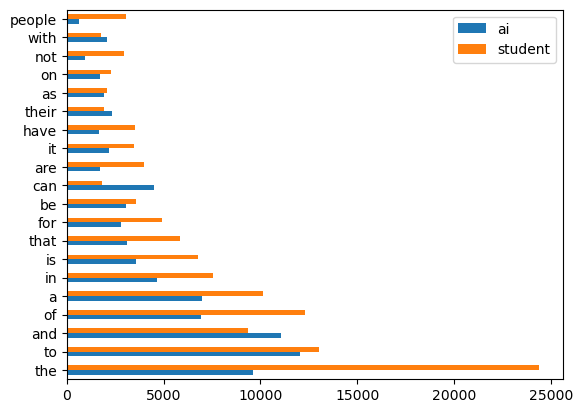

In [25]:
word_counts.sort_values('all', ascending=False
                       )[['ai','student']].head(20).plot.barh()
plt.show()

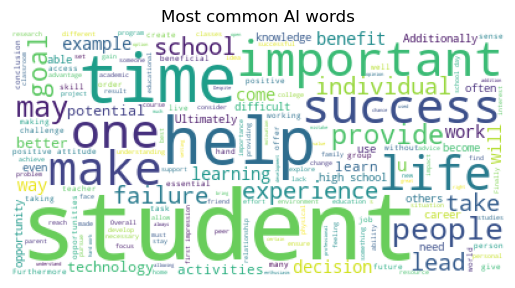

In [26]:
img = WordCloud(background_color='White',
         ).generate(' '.join(ai_words))
plt.imshow(img)
plt.axis('off')
plt.title('Most common AI words')
plt.show()

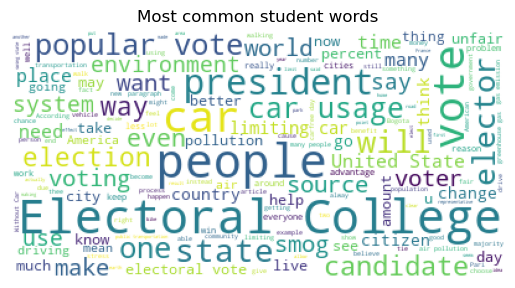

In [27]:
img = WordCloud(background_color='White',
         ).generate(' '.join(student_words))
plt.imshow(img)
plt.axis('off')
plt.title('Most common student words')
plt.show()

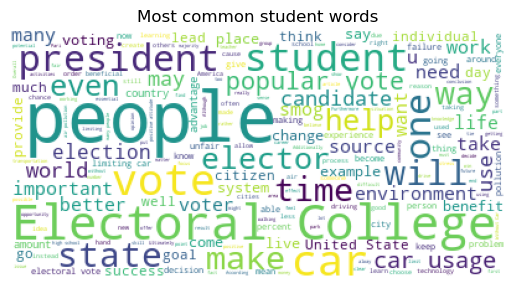

In [28]:
img = WordCloud(background_color='White',
         ).generate(' '.join(all_words))
plt.imshow(img)
plt.axis('off')
plt.title('Most common student words')
plt.show()

In [29]:
dif_words = [ai_words, student_words]

In [30]:
titles = ['ai', 'students']

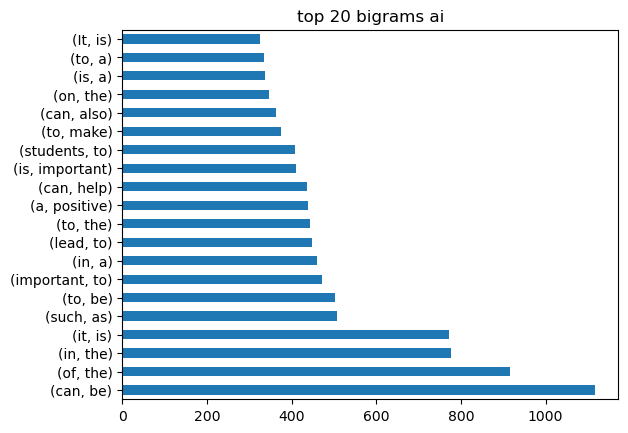

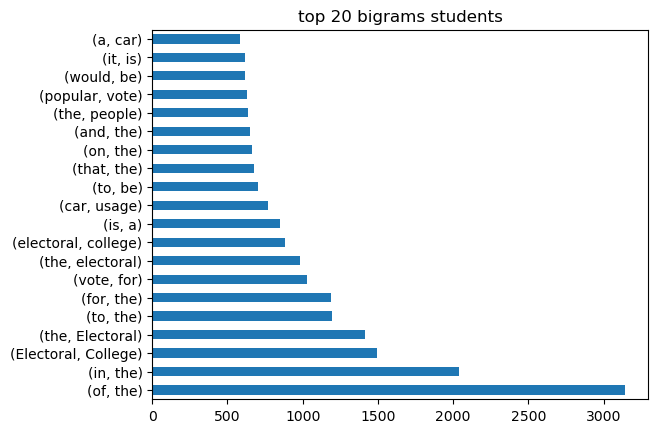

In [31]:
for i in range(2):
    pd.Series(nltk.bigrams(dif_words[i])).value_counts().head(20).plot.barh()
    plt.title(f'top 20 bigrams {titles[i]}')
    plt.show()

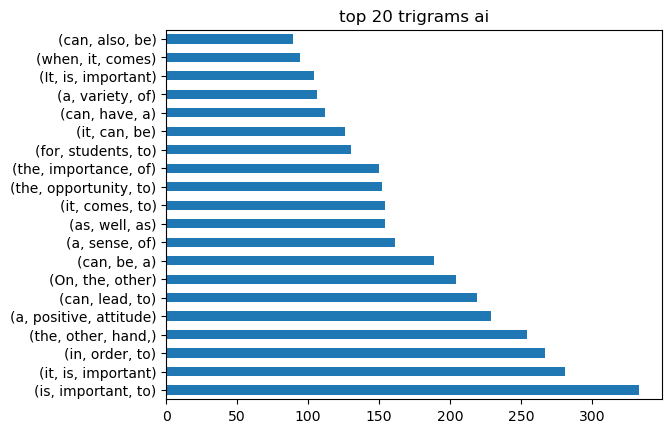

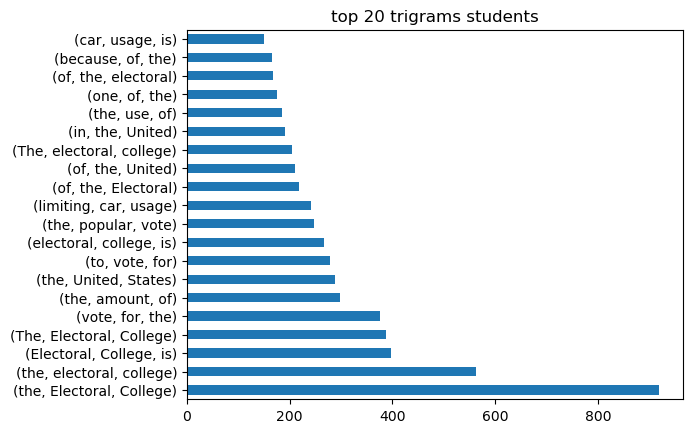

In [32]:
for i in range(2):
    pd.Series(nltk.ngrams(dif_words[i], 3)
             ).value_counts().head(20).plot.barh()
    plt.title(f'top 20 trigrams {titles[i]}')
    plt.show()

In [33]:
mean_ai_wordCount = round(train[train.generated == 1].word_length.mean())
mean_ai_wordCount

202

In [34]:
train[train.generated == 1].word_length.mode()

0    136
Name: word_length, dtype: int64

In [35]:
mean_student_wordCount = round(train[train.generated == 0].word_length.mean())
mean_student_wordCount

551

In [42]:
ai_word_count = train \
[train.generated == 1].word_length
student_word_count = train[train.generated == 0].word_length

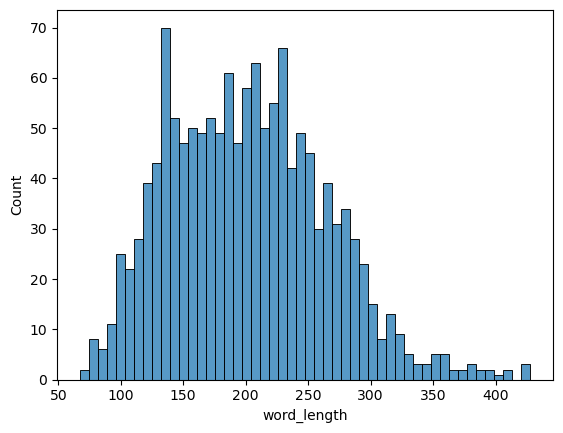

In [37]:
sns.histplot(train[train.generated == 1].word_length, bins=50)
plt.show()


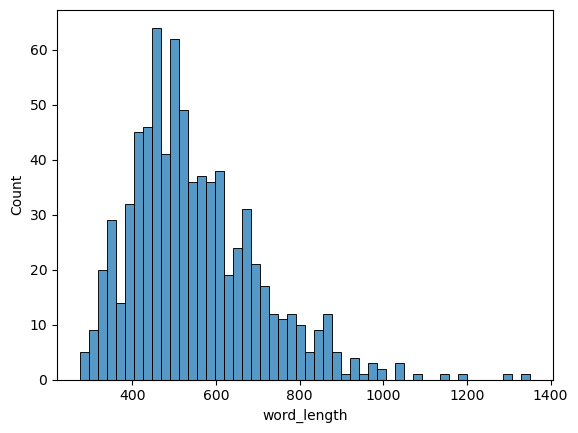

In [38]:
sns.histplot(train[train.generated == 0].word_length, bins=50)
plt.show()


In [39]:
train.generated.value_counts(normalize=True)

1    0.637988
0    0.362012
Name: generated, dtype: float64

### H$0$: There is no significant difference in the mean word counts among students and ai.
### H$a$: There is a significant difference in the mean word counts among students and ai.

In [40]:
ai_word_count

3127    218
2463    140
3089    249
3227    147
1013    308
       ... 
181     244
2246    200
1678    135
196     184
63      191
Name: word_length, Length: 1357, dtype: int64

In [43]:
t, p = stats.ttest_ind(ai_word_count, student_word_count, equal_var=False)
t, p


(-59.757456380453135, 3.725265e-318)

## Let's take a look at the amount of contractions used in AI Vrs Student essays

In [49]:
ai_contracted_words = train[train.generated == 1].contracted_words_used
student_contracted_words = train[train.generated == 0].contracted_words_used

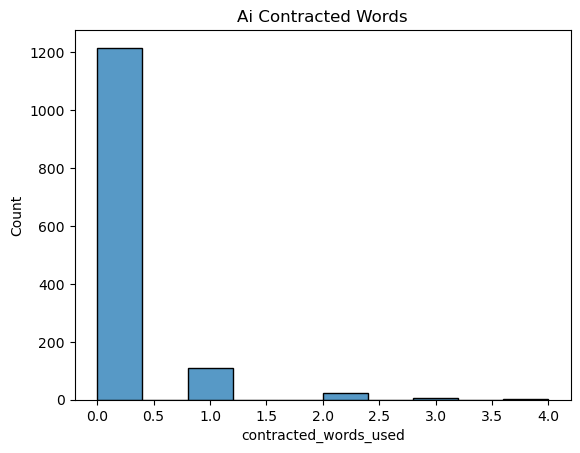

In [44]:
sns.histplot(train[train.generated == 1].contracted_words_used, bins=10)
plt.title('Ai Contracted Words')
plt.show()

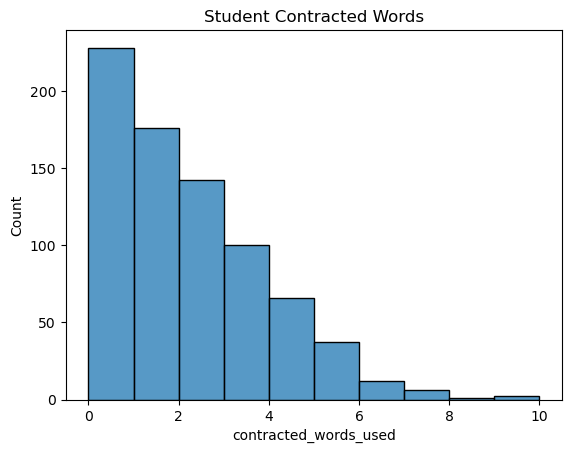

In [46]:
sns.histplot(train[train.generated == 0].contracted_words_used, bins=10)
plt.title('Student Contracted Words')
plt.show()

In [52]:
statistic, p_value = mannwhitneyu(ai_contracted_words, student_contracted_words)


alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference.")
p_value


Reject the null hypothesis. There is a significant difference.


1.5157187841945926e-192